## Implementing a GPT Model from Scratch to Generate Text

**Content**
- Coding a GPT-like LLM that can be trained to generate human-like text.
- Normalizing layer activations to stabilize neural network training.
- Adding shortcut connections in deep neural networks.
- Implementing transformer blocks to create GPT models of various sizes.
- Computing the number of parameters and storage requirements of GPT models.

In [1]:
from torch import nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- **vocab_size** refers to a vocabulary of 50,257 words, as used by the BPE tokenizer (see chapter 2).
- **context_length** denotes the maximum number of input tokens the model can handle via the positional embeddings (see chapter 2).
- **emb_dim** represents the embedding size, transforming each token into a 768-dimensional vector.
- **n_heads** indicates the count of attention heads in the multi-head attention mechanism (see chapter 3).
- **n_layers** specifies the number of transformer blocks in the model, which we will cover in the upcoming discussion.
- **drop_rate** indicates the intensity of the dropout mechanism (0.1 implies a 10% random drop out of hidden units) to prevent overfitting (see chapter 3).
- **qkv_bias** determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations. We will initially disable this, following the norms of modern LLMs, but we will revisit it in chapter 6 when we load pretrained GPT-2 weights from OpenAI into our model (see chapter 6).

In [5]:
import torch
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

**The DummyGPTModel class in this code defines a simplified version of a GPT-like model using PyTorch’s neural network module (nn.Module). The model architecture in the DummyGPTModel class consists of token and positional embeddings, dropout, a series of transformer blocks (DummyTransformerBlock), a final layer normalization (DummyLayerNorm), and a linear output layer (out_head). The configuration is passed in via a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.**

In [6]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


**The output tensor has two rows corresponding to the two text samples. Each text sample consists of four tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer’s vocabulary.**

**The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. When we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.**

In [8]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**Implementing a feed forward network with GELU activations**

GELU and SwiGLU are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively. They offer improved performance for deep learning models, unlike the simpler ReLU.

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

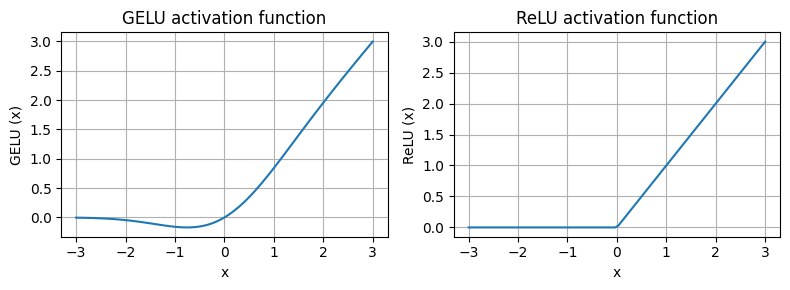

In [19]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The shape of the output tensor is the same as that of the input tensor.

**Next let's add residual (shortcut) connections. Shortcut connection creates an alternative, shorter path for the gradient to flow through the network by skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer. This is why these connections are also known as skip connections. They play a crucial role in preserving the flow of gradients during the backward pass in training.**

In [26]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [27]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [28]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [29]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [30]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [32]:
import sys
sys.path.append("..")
from ch3.ch3_02 import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [33]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### GPT Model

Let’s now replace the DummyTransformerBlock and DummyLayerNorm placeholders with the real TransformerBlock and LayerNorm classes we coded previously to assemble a fully working version of the original 124-million-parameter version of GPT-2.

In [34]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.4167, -0.0676, -0.2001,  ...,  0.3916,  0.1081, -0.1607],
         [ 0.3593, -0.6993, -0.8715,  ..., -0.2451,  0.2673, -0.2367],
         [ 1.0220,  0.0540, -0.3235,  ...,  0.0761, -0.5456, -0.1451],
         [-0.8916,  0.4795, -0.2215,  ...,  0.6458,  0.3718,  0.1394]],

        [[-0.4959, -0.2750, -0.0627,  ...,  0.2587,  0.1351, -0.3289],
         [ 0.2549,  0.3801, -0.1802,  ...,  0.6806, -0.0931,  0.4824],
         [ 1.1538,  0.7210, -0.2097,  ...,  0.8688,  0.1912, -0.2601],
         [-0.0953,  0.5321,  0.2437,  ...,  1.2450, -0.1883, -0.0224]]],
       grad_fn=<UnsafeViewBackward0>)


**As we can see, the output tensor has the shape [2, 4, 50257], since we passed in two input texts with four tokens each. The last dimension, 50257, corresponds to the vocabulary size of the tokenizer. Later, we will see how to convert each of these 50,257-dimensional output vectors back into tokens.**

In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163009536


In [38]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2}")

Number of trainable parameters considering weight tying: 124412160


In [39]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Generating Text

Now that we’ve implemented the GPTModel architecture and saw that it outputs numeric tensors of shape [batch_size, num_tokens, vocab_size], let’s write the code to convert these output tensors into text.

The process by which a GPT model goes from output tensors to generated text involves several steps. These steps include decoding the output tensors, selecting tokens based on a probability distribution, and converting these tokens into human-readable text.

In [40]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [41]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [42]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 41426, 33167, 33239]])
Output length: 10


In [43]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature IT snowballProtect youngstersMu


## Summary
- **Layer normalization** stabilizes training by ensuring that each layer's outputs have a consistent mean and variance
- Shortcut connections, in other words **residual connections** are connections that skip one or more layers by feeding the output of one layer directly to a deeper layer, which helps mitigate the **vanishing gradient problem** when training deep neural networks such as LLMs.
- **Transformer** blocks are a core structural component of **GPT** models, combining **masked multi-head attention** modules with fully connected feed forward networks that use the **GELU** activation function
- GPT models are LLMs with many repeated transformer blocks that have millions to billions of parameters.
- GPT models come in **various sizes**, for example 124, 345, 762, 1542 million parameters which **we can implement** with the **same GPTModel** python class.
- The text-generation capability of a GPT-like LLM involves **decoding** output tensors into human-readable text by sequentially predicting one token at a time based on a given input context.
- **Without training**, a GPT model generates **incoherent text**, which underscores the importance of model training for coherent text generation.